In [79]:
import cv2
import pickle
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [80]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# metaData

In [81]:
path = 'ImgdataSet/cifar-10-batches-py/batches.meta'

In [82]:
meta_data = unpickle(path)#.keys()
print("num_cases_per_batch  = {}".format(meta_data[b'num_cases_per_batch']))
for i,t in zip(meta_data[b'label_names'],range(len(meta_data[b'label_names']))):
    print("lable = {}  | lable_name ={}".format(t,i))
print()
print("num_vis  = {}".format(meta_data[b'num_vis']))

num_cases_per_batch  = 10000
lable = 0  | lable_name =b'airplane'
lable = 1  | lable_name =b'automobile'
lable = 2  | lable_name =b'bird'
lable = 3  | lable_name =b'cat'
lable = 4  | lable_name =b'deer'
lable = 5  | lable_name =b'dog'
lable = 6  | lable_name =b'frog'
lable = 7  | lable_name =b'horse'
lable = 8  | lable_name =b'ship'
lable = 9  | lable_name =b'truck'

num_vis  = 3072


## data in batch

In [83]:
pub_path = 'ImgdataSet/cifar-10-batches-py/'
data_batch = ['data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5']

In [84]:
#將所有資料合成dict
data = {}
for i in data_batch:
    temp = unpickle(pub_path+i)
    data[i] = temp

In [85]:
print('data_batch number : ')
for i in data.keys():
    print(i,end = '  |')
    
print()
print('In one data_batch desc : ')
for i in data['data_batch_1'].keys():
    print(i,end = '  |')

data_batch number : 
data_batch_1  |data_batch_2  |data_batch_3  |data_batch_4  |data_batch_5  |
In one data_batch desc : 
b'batch_label'  |b'labels'  |b'data'  |b'filenames'  |

In [86]:
print(data['data_batch_1'][b'filenames'][0])
print(data['data_batch_1'][b'labels'][0])

b'leptodactylus_pentadactylus_s_000004.png'
6


## show picture

In [87]:
print(data['data_batch_1'][b'filenames'][0])
# print(data['data_batch_1'][b'labels'][0])
img  = data['data_batch_1'][b'data'][0]
class_num = data['data_batch_1'][b'labels'][0]
print(img)
print(class_num)

b'leptodactylus_pentadactylus_s_000004.png'
[ 59  43  50 ... 140  84  72]
6


In [88]:
def showImg(image,class_num):
    image = np.array(image)
    img = image.reshape((32, 32,3), order='F')
    plt.imshow(img)
    plt.axis('off')
    plt.title("Class is {}".format(class_num))
    pass

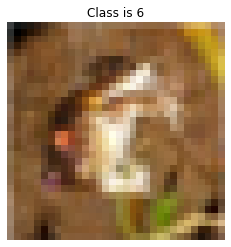

In [89]:
showImg(img,class_num)#v將圖案轉正

# CNN in CPU

In [90]:
import torch
import torch.nn as nn

## 超參數設計

In [91]:
EPOCH = 1        # 跑完幾次所有batchsize              
BATCH_SIZE = 50  # 一次訓練的樣本數目
LR = 0.001       #學習率

## CNN

積卷核的通道數要和輸入要一樣，舉例來說(32, 32,3)是本次的圖片，共有RGB的深度，所以通道數為3
* https://kvirajdatt.medium.com/calculating-output-dimensions-in-a-cnn-for-convolution-and-pooling-layers-with-keras-682960c73870
* conv_size = (image_size-kernel_size+padding*2)/stride + 1
* pool_size = (image_size-pooling_size)/2 + 1  && depth is same

In [92]:
class cnn_net(nn.Module):
    def __init__(self):
        super(cnn_net,self).__init__()
        # 建置各個類神經會用到的模組
        # 定義一個卷積層 輸入深度為3 輸出深度16  kernel_size核大小3*3 stride步伐1 piex padding用於處理卷積的邊界情況 == stride (kernel_size-1)/2
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=2) #https://www.twblogs.net/a/5eec7f6b7301656afddaa356
        # output_size =[(32-3+2*2)/1+1 =34 , 34 ,10]  
        self.relu1 = nn.ReLU() # activation
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) 
        # output_size =[ (34-2)/2+1 = 17, 17,10]  
        
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=5, kernel_size=3, stride=1)  
        # output_size =[(17-3)/1+1 , 15 ,5] 
        self.relu2 = nn.ReLU() # activation
        
        self.pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2) 
        # output_size =[(15-3)/2+1 , 7,5] 
        self.fc = nn.Linear(245,10)
        
                 
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        out = x.view(-1)
        out = self.fc(out)
        
        
        return out
    def retrieve_feature(self,x):
        feature_map1 = self.relu1(x)
        x = self.pool(x)
        feature_map2 = self.relu1(x)
        
        return (feature_map1,feature_map2)

In [93]:
net = cnn_net()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted

## 訓練資料集整理